<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>



# Questions
* When looking at the data I was interested in the Zodiac sign feature, since I already made a study on regression between music interests and the four temperaments when I was in scool. Maybe you had bad results on the Zodiac sign data feature since you mixed up all, whether interested or not in that topic. <br>The question is: Can I predict the Zodiac sign from personal data out of this dataset?
* I’m interested in finding differences between people in different geolocations.<br>Is there a way to predict the place of home from data out of the dataset?

# Imports

In [173]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import requests as req
import json
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import re
from mpl_toolkits.basemap import Basemap

In [174]:
# get profiles and longitude and latitude from csv
profiles = pd.read_csv("profiles.csv")
lonlat = pd.read_csv("lonlat.csv")

# store longituide and latitude in profiles
profiles['lon']=lonlat.values[:, 0]
profiles['lat']=lonlat.values[:, 1]

# Mapping values to categorical data
## Drugs mapping

In [175]:
profiles.drugs=profiles.drugs.replace(np.nan, 'nan', regex=True)
drugs_mapping={
    'never':0,
    'sometimes':1,
    'often':2,
    'nan': 4
}
profiles['drugscode']=profiles.drugs.map(drugs_mapping)

## Zodiac sign month mapping

In [176]:
profiles.sign.value_counts()
profiles.sign.head()
sign = profiles.sign.apply(lambda x: str(x).split(' ')[0])

profiles.sign=profiles.sign.replace(np.nan, '', regex=True)

sign_mapping={
    'aquarius':1,
    'pisces':2,
    'aries':3,
    'taurus':4,
    'gemini':5,
    'cancer':6,
    'leo':7,
    'virgo':8,
    'libra':9,
    'scorpio':10,
    'sagittarius':11,
    'capricorn':12
}

profiles['signcode']=sign.map(sign_mapping)

## Zodiac sign weight mapping

In [177]:
#0: not interested in Zodiac signs
#1: just gave the value
#2: its fun to think about
#3: it matters a lot
regex_fun = re.compile('.*?fun to think about.*?')
regex_not = re.compile('.*?but it doesn.*?')
regex_lot = re.compile('.*?matters a lot.*?')

def get_weight(x):
    if regex_fun.match(x) is not None:
        return 2
    elif regex_lot.match(x) is not None:
        return 3
    elif regex_not.match(x) is not None:
        return 0
    else:
        return 1

signcode_w=[]
for i in profiles['sign']:
    signcode_w.append(get_weight(i))
    
profiles['signcode_w']=signcode_w

## Smokes mapping

In [178]:
smokes_mapping={
    'no':0,
    'trying to quit':1,
    'sometimes':2,
    'when drinking':3,
    'yes':4
}
profiles['smokescode']=profiles.smokes.map(smokes_mapping)

## Location mapping

By the following code I got the longitude and latitude for each location from the google API:
```python
loc = profiles.location
lonlat = pd.DataFrame(columns={'lat','lng'})
for x in loc:
    maps_req = req.get("https://maps.google.com/maps/api/geocode/json?key=###myGeolocationAPIKey###&address="+x)
    maps=maps_req.json()
    coordinates=maps['results'][0]['geometry']['location']
    coordinates = pd.DataFrame([coordinates], columns=coordinates.keys())
    lonlat = lonlat.append([coordinates], ignore_index=True)
```
The output JSON looks like this:
```javascript
{
   "results" : [
      {
         "address_components" : [
            {
               "long_name" : "1600",
               "short_name" : "1600",
               "types" : [ "street_number" ]
            },
            {
                ..................
            },
            {
               "long_name" : "94043",
               "short_name" : "94043",
               "types" : [ "postal_code" ]
            }
         ],
         "formatted_address" : "1600 Amphitheatre Pkwy, Mountain View, CA 94043, USA",
         "geometry" : {
            "location" : {
               "lat" : 37.4227547,
               "lng" : -122.0857292
            },
            "location_type" : "ROOFTOP",
            "viewport" : {
               "northeast" : {
                  "lat" : 37.42410368029149,
                  "lng" : -122.0843802197085
               },
               "southwest" : {
                  "lat" : 37.4214057197085,
                  "lng" : -122.0870781802915
               }
            }
         },
         "place_id" : "ChIJ2eUgeAK6j4ARbn5u_wAGqWA",
         "plus_code" : {
            "compound_code" : "CWF7+4M Mountain View, California, Vereinigte Staaten",
            "global_code" : "849VCWF7+4M"
         },
         "types" : [ "street_address" ]
      }
   ],
   "status" : "OK"
}
```

## Essay mapping

In [179]:
essay_cols = ["essay0","essay1","essay2","essay3","essay4","essay5","essay6","essay7","essay8","essay9"]

all_essays = profiles[essay_cols].replace(np.nan, '', regex=True)

all_essays = all_essays[essay_cols].apply(lambda x: ' '.join(x), axis=1)

profiles['all_essays']=all_essays

profiles["essay_len"] = all_essays.apply(lambda x: len(x))

# Rendering for data analysis
## Plotting Zodiac signs over months and weight

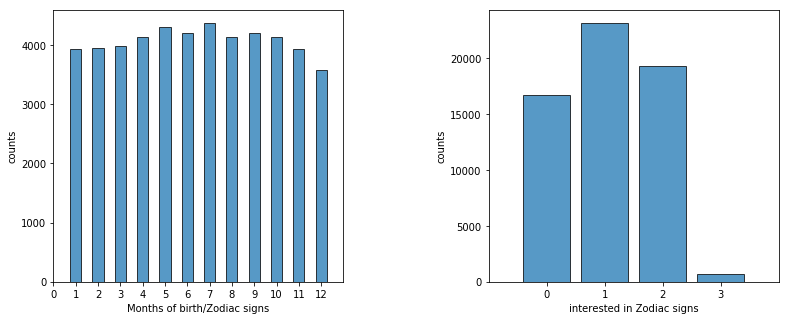

In [180]:
plt.rcParams["patch.force_edgecolor"] = True

fig=plt.figure(1, figsize=(13, 5))
plt.subplot(121)
plt.hist(profiles.signcode.dropna(), bins=np.arange(14)-0.5, alpha=0.75, rwidth=0.5)
plt.xlabel('Months of birth/Zodiac signs')
plt.ylabel('counts')
plt.xticks(range(13))
plt.xlim(0,13)

plt.subplot(122)
plt.hist(profiles.signcode_w.dropna(), bins=np.arange(6)-0.5, alpha=0.75, rwidth=0.8)
plt.xlabel('interested in Zodiac signs')
plt.ylabel('counts')
plt.xticks(range(4))
plt.xlim(-1,4)

plt.subplots_adjust(wspace=0.5)

plt.show()

## Plotting geolocation of members

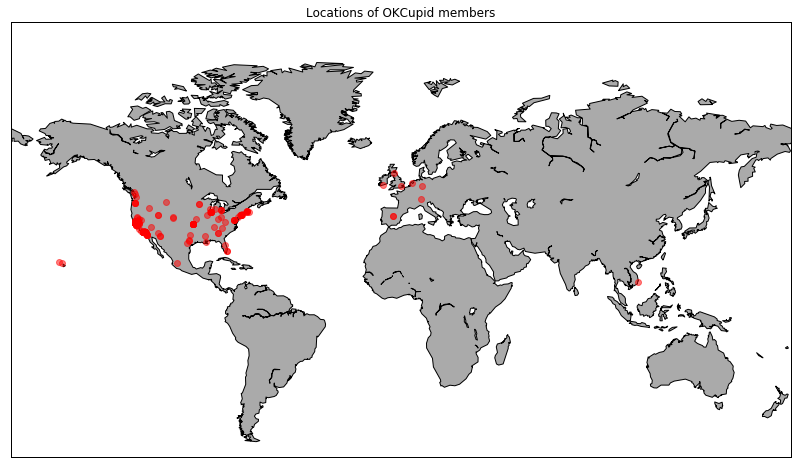

In [181]:
fig1=plt.figure(1, figsize=(20, 8))
m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='#AAAAAA',lake_color='#FFFFFF')

m.drawmapboundary(fill_color='#FFFFFF')
plt.title("Locations of OKCupid members")

#plotting each point
x1, y1 = m(profiles['lon'].values.tolist(),profiles['lat'].values.tolist())
m.scatter(x1, y1, zorder=100, color='red', alpha=0.5)

plt.show()

## Exploring east west of Atlantic ocean

In [182]:
profiles['east_of_great_plains']=profiles['lon'].apply(lambda x: x > -24)
profiles['east_of_great_plains'].value_counts()

False    59937
True         9
Name: east_of_great_plains, dtype: int64

## Exploring east west of Great Plains

In [183]:
profiles['east_of_great_plains']=profiles['lon'].apply(lambda x: x > -100)
profiles['east_of_great_plains'].value_counts()

False    59875
True        71
Name: east_of_great_plains, dtype: int64

## Exploring center of population

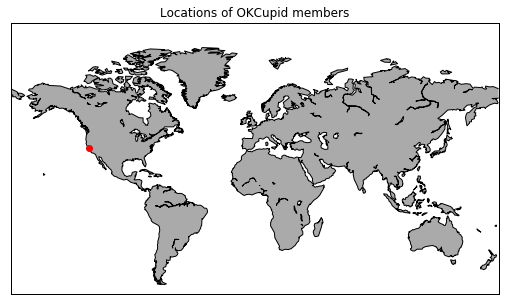

In [184]:
fig1=plt.figure(1, figsize=(13, 5))
m = Basemap(projection='mill',llcrnrlat=-60,urcrnrlat=90, llcrnrlon=-180,urcrnrlon=180,resolution='c')
m.drawcoastlines()
m.fillcontinents(color='#AAAAAA',lake_color='#FFFFFF')

m.drawmapboundary(fill_color='#FFFFFF')
plt.title("Locations of OKCupid members")

# plotting mean value
x1, y1 = m(profiles['lon'].values.mean(),profiles['lat'].values.mean())
m.scatter(x1, y1, zorder=100, color='red')

plt.show()

## Exploring income

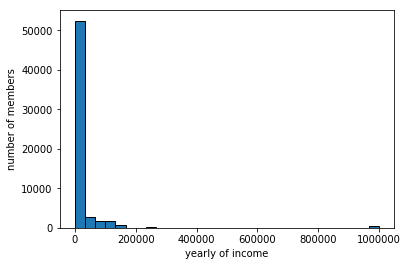

In [185]:
plt.hist(profiles.income, bins=30)
plt.ylabel('number of members')
plt.xlabel('yearly of income')
plt.show()

## Exploring height

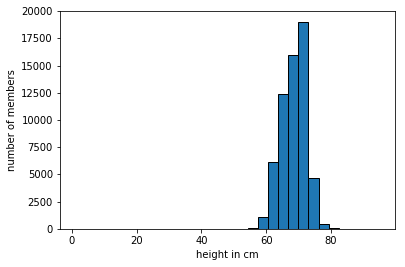

In [186]:
plt.hist(profiles.height.dropna(), bins=30)
plt.ylabel('number of members')
plt.xlabel('height in cm')
plt.show()

## Exploring smoking

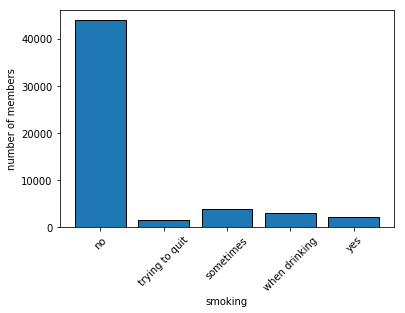

In [187]:
values=profiles.smokescode.dropna().value_counts().sort_index()
smokes_mapping_inv = {v: k for k, v in smokes_mapping.iteritems()}

plt.bar(smokes_mapping_inv.values(), values)
plt.ylabel('number of members')
plt.xlabel('smoking')
plt.xticks(rotation=45)

plt.show()

## Exploring drugs

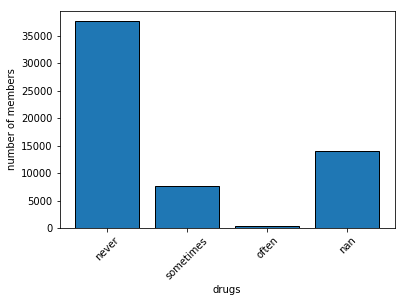

In [188]:
values=profiles.drugscode.dropna().value_counts().sort_index()
drugs_mapping_inv = {v: k for k, v in drugs_mapping.iteritems()}

plt.bar(drugs_mapping_inv.values(), values)
plt.ylabel('number of members')
plt.xlabel('drugs')
plt.xticks(rotation=45)

plt.show()

<H1>Normalize</H1>

In [189]:
import sklearn.preprocessing as pre
feature_data_prescaled = profiles[['smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', 'income', 'age']].dropna()

x = feature_data_prescaled.values
min_max_scaler = pre.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)

feature_data = pd.DataFrame(x_scaled, columns=feature_data_prescaled.columns)

# show the normalized data
feature_data.head(3)

,smokescode,drugscode,essay_len,signcode,signcode_w,height,income,age
0,0.5,0.00,0.027372,0.363636,0.333333,0.787234,0.000000,0.043956
1,0.0,0.25,0.015000,0.454545,0.333333,0.734043,0.080001,0.186813
2,0.0,1.00,0.057215,0.090909,0.000000,0.712766,0.000000,0.219780


# Classification
## Classify Zodiac signs to word couts KNN

In [190]:
%%time
profiles_explore=profiles[['all_essays', 'signcode']].dropna()

train_data, test_data, train_labels, test_labels = \
                            train_test_split(profiles_explore['all_essays'], \
                            profiles_explore['signcode'], test_size=0.2, random_state=1)


counter = CountVectorizer()
counter.fit(profiles_explore['all_essays'])

train_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)

classifier = MultinomialNB()
classifier.fit(train_counts, train_labels)
predictions = classifier.predict(test_counts)

print(classification_report(test_labels, predictions))
%time

              precision    recall  f1-score   support

         1.0       0.07      0.01      0.02       782
         2.0       0.08      0.04      0.05       789
         3.0       0.11      0.03      0.05       804
         4.0       0.09      0.17      0.11       859
         5.0       0.09      0.13      0.11       874
         6.0       0.09      0.07      0.08       846
         7.0       0.08      0.19      0.12       860
         8.0       0.07      0.09      0.08       858
         9.0       0.08      0.13      0.10       754
        10.0       0.10      0.06      0.08       841
        11.0       0.07      0.05      0.06       789
        12.0       0.17      0.01      0.02       722

   micro avg       0.08      0.08      0.08      9778
   macro avg       0.09      0.08      0.07      9778
weighted avg       0.09      0.08      0.07      9778

Wall time: 0 ns
Wall time: 34.2 s


## Classify Zodiac signs to word counts KNN

In [ ]:
%%time
profiles_explore=profiles[['all_essays', 'signcode']].dropna()

train_data, test_data, train_labels, test_labels = \
                            train_test_split(profiles_explore['all_essays'], \
                            profiles_explore['signcode'], test_size=0.2, random_state=1)


counter = CountVectorizer()
counter.fit(profiles_explore['all_essays'])

train_counts = counter.transform(train_data)
test_counts = counter.transform(test_data)

classifier = KNeighborsClassifier(n_neighbors=50)
classifier.fit(train_counts, train_labels)
predictions = classifier.predict(test_counts)

print(classification_report(test_labels, predictions))
%time

## Comment
I tried to find a regression with Naive Bayes Classifier, but I got approximately the same value as you: 0.08
The KNN runs much longer than the Naive Bayes, but results are similar

## Classification on income-levels vs others

In [ ]:
%%time
train_data, test_data, train_labels, test_labels = \
    train_test_split(feature_data[['smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', 'age']], \
    feature_data_prescaled['income'], test_size=0.2, random_state=300)
    
classifier = MultinomialNB()
classifier.fit(train_data, train_labels)
predictions = classifier.predict(test_data)

print(classification_report(test_labels, predictions))
%time

## Comment
Here we can see that the model predicts 80% af the members that does not give out their income. But since these are overall 80% its not a worthful result.

# Regression
## Regression on income-levels vs others

In [ ]:
%%time
train_data, test_data, train_labels, test_labels = \
    train_test_split(feature_data[['smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', 'age']], \
    feature_data['income'], test_size=0.2, random_state=300)
    
regression = LinearRegression()
regression.fit(train_data, train_labels)
predictions = regression.predict(test_data)

print(r2_score(test_labels, predictions))
%time

## Comment
Whith this model the income can not be predicted from 'smokescode', 'drugscode', 'essay_len', 'signcode', 'signcode_w', 'height', or 'age'. There is no correlation!

## Regression on income-levels vs others

In [ ]:
%%time
train_data, test_data, train_labels, test_labels = \
    train_test_split(feature_data[['income', 'smokescode', 'drugscode', 'essay_len', 'height', 'age']], \
    feature_data[['signcode_w', 'signcode']], test_size=0.2, random_state=300)
    
regression = KNeighborsRegressor()
regression.fit(train_data, train_labels)
predictions = regression.predict(test_data)

print(r2_score(test_labels, predictions))
%time

## Comment
Here we see that the model performs arbitrary worse. We see this $r^2$ is negative (-0.17087304731468433). If the model always predicts the expected value of y, disregarding the input features, it would get a $r^2$ score of 0.0 [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

As we have seen before in the Zodiac sign Classification there seems to be no chance to predict the month of birth.  
> Penny: Um, me, okay, I'm Sagittarius, which probably tells you way more than you need to know.

> Sheldon: Yes, it tells us that you participate in the mass cultural delusion that the Sun's apparent position relative to arbitrarily defined constellations and the time of your birth somehow effects your personality.

# Conclusion

My questions from the beginning were answered with <strong>NO</strong>:
* The geolocation was focused on California. So I was not able to see significant differences between people from other states or countries.
* Also the zodiac signs was not as expacted. The only thing I was able to see from the data is that in summer there are more births than in winter.

In the next project
* I would like to have more exact geolocations (maybe from mobile tracking)
* I need more knowledge about the people living there. There were only 9 people from the east side of the atlantic ocean, where I live.
* Next time I would explore more other data that is difficult to map to numbers, or combine different features where I know about a correlation, to one feature. For example body_type, diet and status.

# Render table of content

In [ ]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')